# Comparison of the networks for all time steps

In [1]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Import custom libraries
import pcst_utils_2 as pcst

In [2]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_utils_2' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils_2.py'>

In [3]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

# Significant TFs

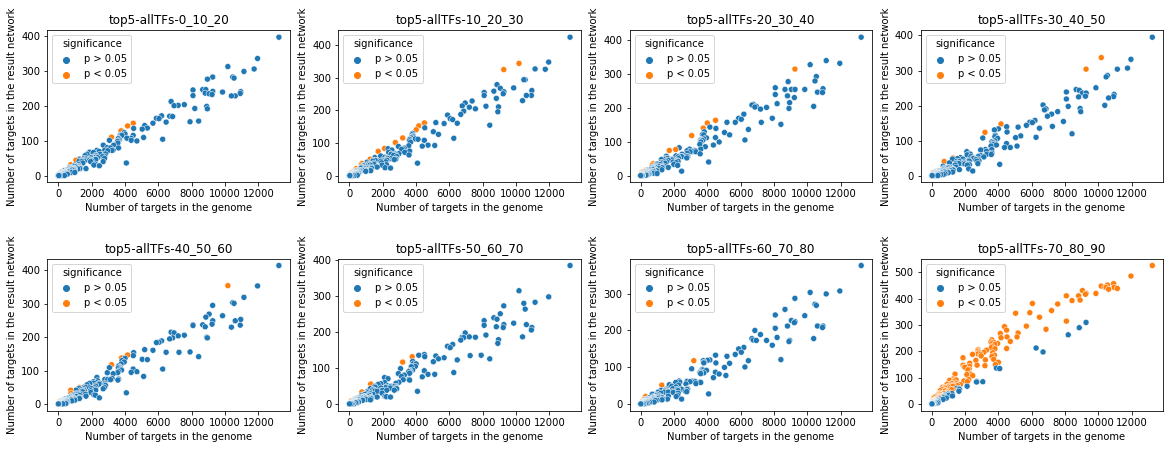

In [4]:
net_dir = pcst.get_net_dir_all_stages(save_dir, "allTFs", "top5")
net_stats, target_counts = pcst.compare_networks(net_dir, data_dir, fig_dir, save_dir)

The last model includes much more significant TFs than the models for the earlier time steps, meaning that many of the included TFs target a lot of the genes that are differentially expressed between the 80s and 90s group.

# General network statistics


In [5]:
net_stats.iloc[:, 0:8]

,n_nodes,n_edges,n_prized_nodes,n_Steiner_nodes,n_TFs,n_incl_TFs,n_prized_TFs,n_significant_TFs
top5-allTFs-0_10_20,2064,45349,1373,691,356,248,159,8
top5-allTFs-10_20_30,2062,45611,1401,661,356,254,173,23
top5-allTFs-20_30_40,2118,45825,1406,712,344,247,166,17
top5-allTFs-30_40_50,2071,45195,1407,664,338,257,182,7
top5-allTFs-40_50_60,2098,44643,1409,689,351,243,174,10
top5-allTFs-50_60_70,2122,43750,1402,720,347,236,163,6
top5-allTFs-60_70_80,2081,43089,1410,671,347,242,169,6
top5-allTFs-70_80_90,2123,55553,1443,680,387,273,193,171


All of the networks consist of around 2100 nodes of which around 700 are Steiner node. Around 250 TFs are included in each of the networks.

# Intersections of the TFs

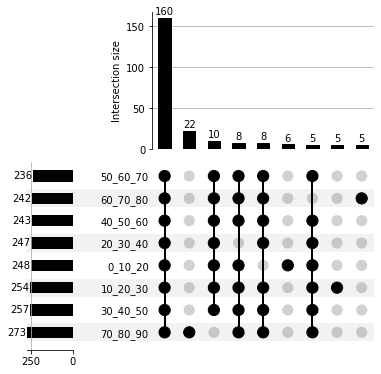

In [6]:
incl_TFs = [[tf[:-4] for tf in net_stats.iloc[net, 8]] for net in range(8)]

intersections = from_contents({'0_10_20': incl_TFs[0], 
                               '10_20_30': incl_TFs[1],
                               '20_30_40': incl_TFs[2],
                               '30_40_50': incl_TFs[3], 
                               '40_50_60': incl_TFs[4],
                               '50_60_70': incl_TFs[5],
                               '60_70_80': incl_TFs[6],
                               '70_80_90': incl_TFs[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_allTFs_top5.png')

Most of the TFs (160 out of the 250 per network) occur in each network.

# Analyses of the TFs that occur in all 8 networks

## Numbers of DE targets per net

In [8]:
# Get number of DE targets for the TFs in each of the networks
targets_shared_TFs = pd.DataFrame(index = set.intersection(*map(set,incl_TFs)))

for index, (name, df) in enumerate(target_counts.items()):
    df.index = df.index.str.replace("_tr0", "")
    if index == 0: 
        df = df[['protein1_all_targets', 'protein1_incl_targets']]
        df.columns = ['n_targets', name.split("-")[2]]
    else:
        df = df[['protein1_incl_targets']]
        df.columns = [name.split("-")[2]]
    targets_shared_TFs = targets_shared_TFs.join(df)

targets_percent = targets_shared_TFs.iloc[:,1:].div(targets_shared_TFs.n_targets, axis=0)
targets_shared_TFs.head()

,n_targets,0_10_20,10_20_30,20_30_40,30_40_50,40_50_60,50_60_70,60_70_80,70_80_90
TAF7,211,8,6,5,3,9,6,4,19
RCOR1,323,6,6,5,3,7,13,7,19
RBCK1,369,1,6,3,1,3,4,6,33
RELA,233,5,6,3,5,7,8,6,18
UBN1,143,4,10,8,7,6,5,5,2


## TF correlations 

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

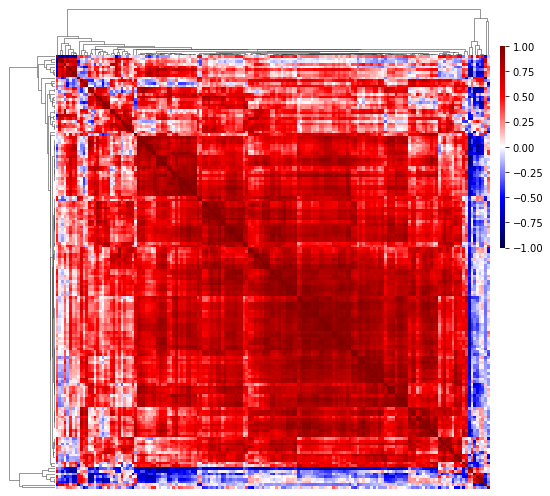

In [9]:
# Correlation between the TFs
corr_TFs = targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman")
plt.figure()
sns.clustermap(corr_TFs,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = -1, vmax = 1, figsize=(7,7))
plt.show()

The heatmap is clearly clustered into two distinct groups of TFs <br> --> analyse which TFs are in the small cluster and how their trajectories differs from the others

## Analyses of the two high-level clusters

In [10]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman"))
print('Number of TFs in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of TFs in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Number of TFs in cluster 0 = 8
Number of TFs in cluster 1 = 152


In [11]:
# TFs in the small cluster
TF_clusters = pd.DataFrame({'TF': targets_shared_TFs.iloc[:, 1:].index, 
                            'cluster': clustering.labels_})
selected_TFs = TF_clusters[TF_clusters['cluster'] == 0].TF.tolist()
selected_TFs

['UBN1', 'ZFX', 'HNF1B', 'GLIS1', 'HDAC6', 'HOXB13', 'GATA4', 'TCF4']

7/8 of these TFs occur also in the networks with the top10 DE genes

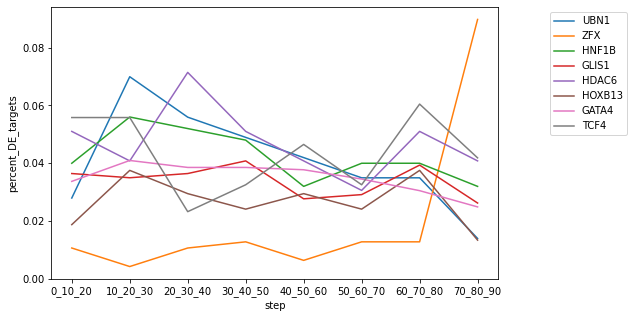

In [12]:
# plot number of targets for the selected TFs
targets_selection = targets_percent[targets_percent.index.isin(selected_TFs)]
targets_selection.reset_index(inplace=True)
                                    
targets_selection = pd.melt(targets_selection, id_vars = ['index'],
       var_name='step', value_name = 'percent_DE_targets')
targets_selection.columns = ['TF', 'step', 'percent_DE_targets']

plt.figure(figsize = (8, 5))
g = sns.lineplot(x='step', y='percent_DE_targets', hue='TF', 
             data=targets_selection)
g.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [13]:
targets_percent.reset_index(inplace=True)

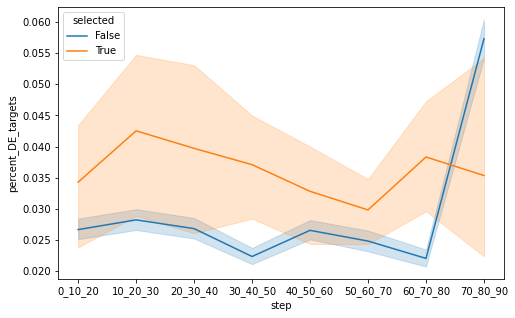

In [14]:
# plot trajectory of the number of targets in the two clusters
targets_long = pd.melt(targets_percent, id_vars = ['index'],
       var_name='step', value_name = 'percent_DE_targets')
targets_long.columns = ['TF', 'step', 'percent_DE_targets']
targets_long['selected'] = np.where(targets_long['TF'].isin(selected_TFs), 'True', 'False')

plt.figure(figsize = (8, 5))
sns.lineplot(data=targets_long,
             x='step', y='percent_DE_targets',
             hue="selected")

plt.show()

Possible explanations: most TFs (blue line) have the highest number of DE targets in the last model, which could be due to the opening and higher accessibility of the chromatin during aging such that genes that are not specific to aging, but targeted by many of the common TFs get differentially expressed. The trend for the orange line including only a small number of TFs (15) however is inversed, which means that they have less DE targets during aging. One reason for that could be that early during aging only genes that play a role in development/aging are differentially expressed, whereas in the last model many non-aging-specific genes are DE, so the majority of the TFs (blue) has more targets there, whereas the age-specific TFs (orange) have less targets in the last model???
<br> Expression of the 15 TFs from the orange cluster (only 11 are shown since two of them have TPM < 0.1 for all time points and 2 are not included in the RNAseq data):

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

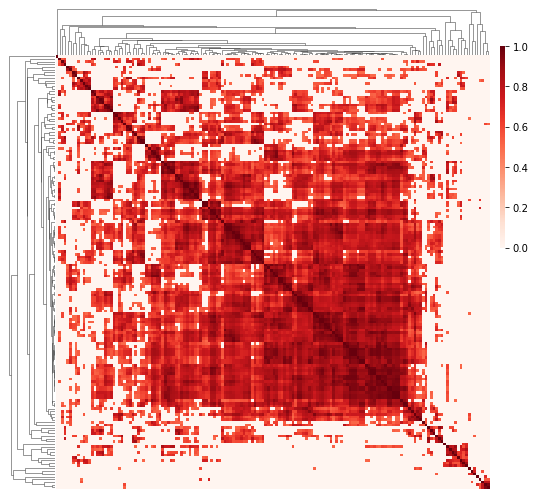

In [15]:
# Filter correlation matrix
corr_TFs_0 = corr_TFs.copy()
corr_TFs_0[corr_TFs_0 < 0.5] = 0

plt.figure()
sns.clustermap(corr_TFs_0,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='Reds', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = 0, vmax = 1, figsize=(7,7))
plt.show()

In [16]:
# Create network
corr_long = pd.melt(corr_TFs_0.reset_index(), id_vars='index')
corr_long = corr_long[(corr_long['value'] > 0) & (corr_long['index'] != corr_long['variable'])]
corr_long.columns = ['protein1', 'protein2', 'corr']
corr_long

network = nx.from_pandas_edgelist(corr_long, 'protein1', 'protein2', 'corr')
# add clusters as node attributes
clusters = {TF: TF_clusters.loc[TF_clusters['TF'] == TF, 'cluster'].tolist() for TF in list(network.nodes())}
nx.set_node_attributes(network, clusters, name='cluster')
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_corr_0.5_top5.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TF_corr_0.5_top5.html')

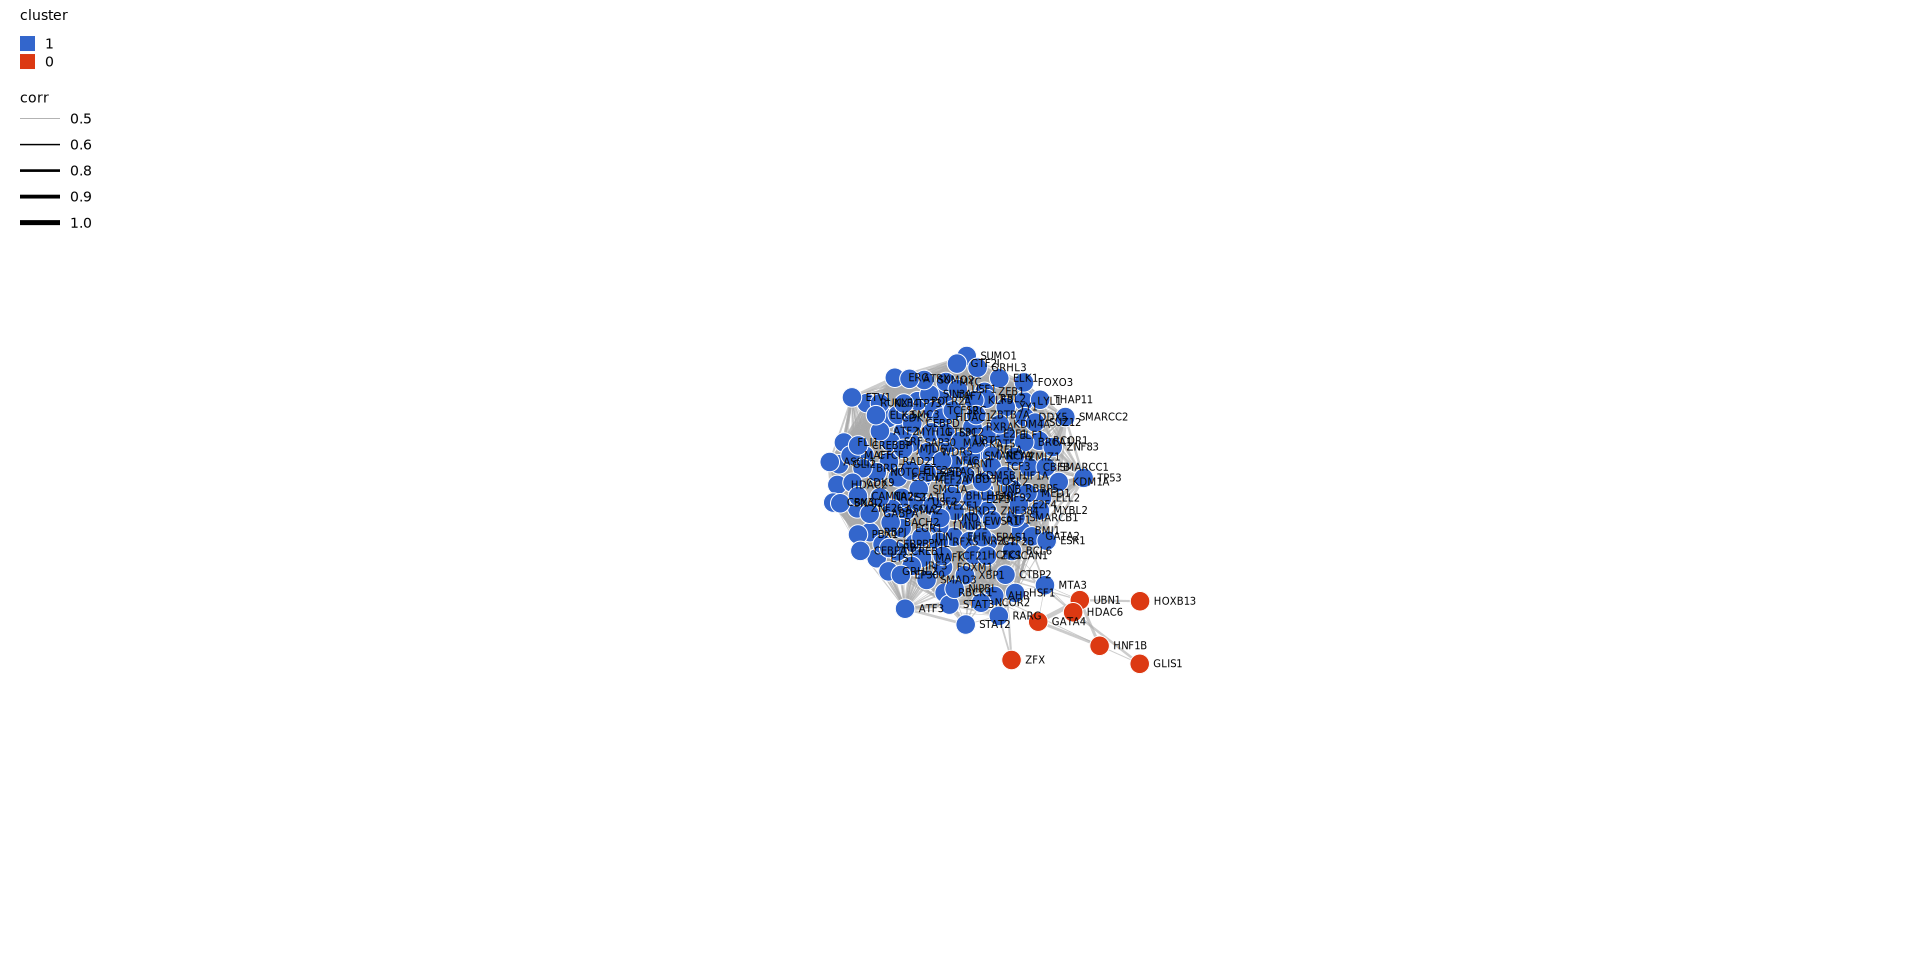

In [17]:
# network image created from the interactive html file
SVG(fig_dir+"net_top5.svg")